# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Jørn Bøni Hofstad"
student2 = "Place holder"

        

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

# MY stuff (Some utilities)
####################################################################
GLOBAL_N_EPOCHS = 50 # Controll variable for debugging the program
DEBUG_BATCH_SIZE = 128
NELDER_MEAD_ITTERATIONS = 20
# Does not kill the program if we are not allowed to save to disk, shows the figure instead (For Jupyter notebook)
def reckless_savefig(fig, filename):
    try: 
        fig.savefig(filename)
    except: 
        print("Unable to save plot with filename:", filename )
        fig.show()
        
        
        
# I moved this up to the beginning
####################################################################        
        
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig



Using TensorFlow backend.


### Plotting

In [3]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

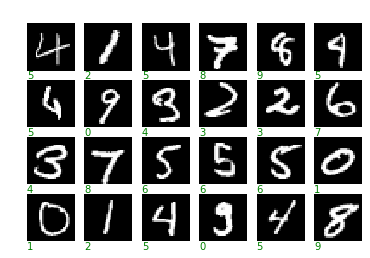

In [4]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist




(x_number_train_raw, y_number_train_raw), (x_test_raw, y_test_raw) = mnist.load_data()
(x_fashion_train_raw, y_fashion_train_raw), (x_fashion_test_raw, y_fashion_test_raw) = fashion_mnist.load_data()

#print( x_number_train[0],y_number_train[] )
#y_number_train[0] =9
#plot_some_samples(x_number_train[0:1], y_number_train[0:1])
plot_some_samples(x_number_train_raw, y_number_train_raw)
# plot_some_samples(x_fashion_train, y_fashion_train)
# I do not understand the rest of  question 



x_number_train = x_number_train_raw.reshape(x_number_train_raw.shape[0], x_number_train_raw.shape[1]*x_number_train_raw.shape[2])/np.max(x_number_train_raw)
x_test = x_test_raw.reshape(x_test_raw.shape[0], x_test_raw.shape[1]*x_test_raw.shape[2])/np.max(x_test_raw)


x_fashion_train = x_fashion_train_raw.reshape(x_fashion_train_raw.shape[0], x_fashion_train_raw.shape[1]*x_fashion_train_raw.shape[2])/np.max(x_fashion_train_raw)
x_fashion_test = x_fashion_test_raw.reshape(x_fashion_test_raw.shape[0], x_fashion_test_raw.shape[1]*x_fashion_test_raw.shape[2])/np.max(x_fashion_test_raw)

Answer to question 2:


The green numbers below each number is theri index in the table representing each different class ( This list is 1 -indexed) 

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [5]:
y_number_train = keras.utils.to_categorical(y_number_train_raw)
y_test = keras.utils.to_categorical(y_test_raw)

y_fashion_train = keras.utils.to_categorical(y_fashion_train_raw)
y_fashion_test = keras.utils.to_categorical(y_fashion_test_raw)

In [6]:
x_number_train = x_number_train_raw.reshape(x_number_train_raw.shape[0], x_number_train_raw.shape[1]*x_number_train_raw.shape[2])/np.max(x_number_train_raw)

x_test = x_test_raw.reshape(x_test_raw.shape[0], x_test_raw.shape[1]*x_test_raw.shape[2])/np.max(x_test_raw)

x_fashion_train = x_fashion_train_raw.reshape(x_fashion_train_raw.shape[0], x_fashion_train_raw.shape[1]*x_fashion_train_raw.shape[2])/np.max(x_fashion_train_raw)
x_fashion_test = x_fashion_test_raw.reshape(x_fashion_test_raw.shape[0], x_fashion_test_raw.shape[1]*x_fashion_test_raw.shape[2])/np.max(x_fashion_test_raw)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

(784,)
(60000, 784)
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 3s 52us/step - loss: 1.7515 - acc: 0.4649 - val_loss: 1.1779 - val_acc: 0.6932
Epoch 2/5
48000/48000 [==============================] - 1s 16us/step - loss: 0.9091 - acc: 0.7540 - val_loss: 0.6779 - val_acc: 0.8191
Epoch 3/5
48000/48000 [==============================] - 1s 17us/step - loss: 0.6289 - acc: 0.8247 - val_loss: 0.5226 - val_acc: 0.8558
Epoch 4/5
48000/48000 [==============================] - 1s 18us/step - loss: 0.5164 - acc: 0.8556 - val_loss: 0.4504 - val_acc: 0.8704
Epoch 5/5
48000/48000 [==============================] - 1s 18us/step - loss: 0.4507 - acc: 0.8727 - val_loss: 0.4007 - val_acc: 0.8867
10000
[1. 1. 1. ... 1. 1. 1.]
[   8   33   46 ... 9982 9986 9992]
dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])
(784,)
(60000, 784)
Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 1s 19us

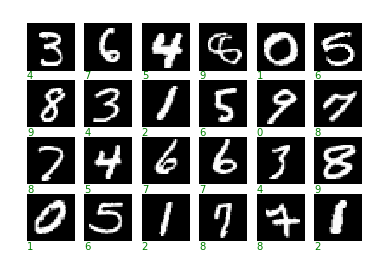

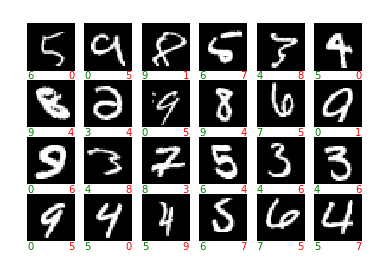

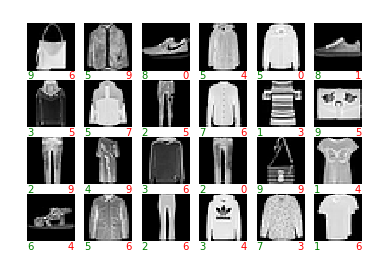

In [7]:
#%%
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
def make_model( depth, one_input= None, shape = None, batch_size = None):
    
    if (shape == None): 
        if one_input is None:
            assert("Give a sample of the input, or the shape, to make_model (kwargs)")
        print(one_input.shape)
        shape = one_input.shape

    
    
    model = Sequential( [Dense(32, input_shape=shape, batch_size = batch_size)] )
    
    
    for i in range(depth): 
            model.add(Activation('relu'))
            
            model.add(Dense(10))

    model.add( Activation("softmax"))
    
    my_optimizer = optimizers.SGD( )

    model.compile(
                  loss = "categorical_crossentropy", 
                  metrics = ["acc"],
                  optimizer= my_optimizer
                 )
    return model


def get_mislabeled_indexes(model): 
    guesses= model.predict_classes(x_test).reshape((-1,))
    ziped = ([(ind, guess) for ind, guess in enumerate(guesses)])
    print(len(ziped))
    label_attempts = np.array([ y_test[index] for index in ziped ])
    is_mislabeled = True != label_attempts
    print(label_attempts)
    mislabeled_indexes = np.arange( is_mislabeled.shape[0] )[is_mislabeled]
    print(  mislabeled_indexes)
    return mislabeled_indexes, guesses

# The green number is the index of the number in an array 
# The number corresponds to the picture +1 mod 10 
def task_2(): # Keep the momory from blowing up 
    plot_some_samples(x_number_train, y_number_train)

    # Make Mnist network 
    batch_size = 128
    model = make_model(2, one_input=x_number_train[0] , batch_size = batch_size)
    print(x_number_train.shape)


    history = model.fit(x_number_train, y_number_train, epochs = 5, batch_size = batch_size, validation_split = 0.2)

    mislabeled_indexes, guesses = get_mislabeled_indexes(model)


    plot_some_samples(x_test, y_test, guesses, mislabeled_indexes)
    # THe green numbers are the actual label, while the red number is the incorrect, estimated label 
    print( history.history.keys())

    #plot_history(history, "10 epochs")




    # Make Fashion network 
    batch_size = 128
    model_fashion = make_model(2, one_input=x_fashion_test[0] , batch_size = batch_size)
    print(x_number_train.shape)


    history_fashion = model_fashion.fit(x_fashion_train, y_fashion_train, epochs = 5, batch_size = batch_size, validation_split = 0.2)

    mislabeled_indexes_fashion, guesses_fashion = get_mislabeled_indexes(model_fashion)


    plot_some_samples(x_fashion_test, y_fashion_test, guesses, mislabeled_indexes)
    # THe green numbers are the actual label, while the red number is the incorrect, estimated label 
    print( history_fashion.history.keys())

    #plot_history(history, "10 epochs")

task_2()

Answer to question 10:

The green number is the index of the number in an array 
The number corresponds to the picture +1 mod 10 

THe green numbers are the actual label, while the red number is the incorrect, estimated label 

A similair case also counts for the fashion list, but the labels correspond to a type of clothing. 

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 1s 21us/step - loss: 3.4942 - acc: 0.1018 - val_loss: 2.3202 - val_acc: 0.1013
Epoch 2/2
48000/48000 [==============================] - 1s 17us/step - loss: 2.3144 - acc: 0.0991 - val_loss: 2.3059 - val_acc: 0.0983
Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 1s 25us/step - loss: 14.0292 - acc: 0.1278 - val_loss: 14.5009 - val_acc: 0.1003
Epoch 2/2
48000/48000 [==============================] - 1s 20us/step - loss: 14.5076 - acc: 0.0999 - val_loss: 14.5009 - val_acc: 0.1003


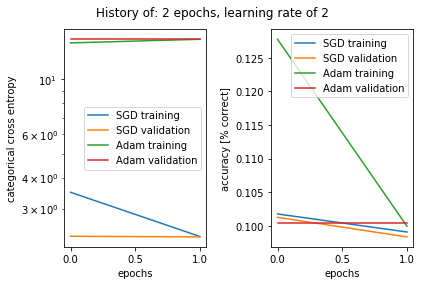

In [13]:




#My code 
########################

def make_model( features,labels, optimizer, learning_rate = None ): 
    # Input layer
    model = Sequential( [Dense(32, input_shape=features[0].shape, batch_size = 128)] )
    model.add(Activation('relu'))

    # Hidden layer
    model.add(Dense(128))
    model.add(Activation('relu'))

    # Output layer
    model.add(Dense(len(labels[0]))) 
    model.add( Activation("softmax"))

    model.compile(
                loss = "categorical_crossentropy", 
                metrics = ["acc"],
                optimizer= optimizer(learning_rate)
                )
    return model

# Variable parameters 

def compare_optimizers(
    features = None, 
    labels = None, 
    learning_rate = None, 
    title = ""

):
    #1)
    SGD_model  = make_model(features,labels, optimizers.SGD,  learning_rate=0.04)
    Adam_model = make_model(features,labels, optimizers.Adam, learning_rate=0.04)
    examples = [
        ("SGD", SGD_model), 
        ("Adam", Adam_model)
    ]
    histories = {}
    for name, model in examples:
        history = model.fit(        features, 
                                    labels,
                                    epochs = GLOBAL_N_EPOCHS,
                                    batch_size = 128,
                                    validation_split = 0.2,
                                )    
        histories[name]= history
    comparison_title = "Task 3 ( {} ) ".format(title)
    comparison_path = "plots/task_3/{}.png".format(title)
    fig = comparison_plot(histories["SGD"], histories["Adam"],"SGD", "Adam", title)
    reckless_savefig(fig, comparison_path)
    
    
def task_3():

    # 3.1 to 3.3
    compare_optimizers(features=x_number_train, labels=y_number_train, learning_rate=0.04, title="First comparison")

    learning_rate_list = np.arange(0.01, 0.1, 0.01)
    learning_sets = [(x_fashion_train, y_fashion_train, "Fashion MNIST"), (x_number_train, y_number_train, "NUMBER MNIST")]



    learning_sets = [
        (x_fashion_train, y_fashion_train, "fashion"),
        (x_number_train , y_number_train , "number"),
    ]
    # Implementation
    for features, labels, name in learning_sets: 
        for learning_rate in learning_rate_list: 
            plot_title = "Task 3 learning_set: {}, learning_rate: {}, epochs: {}".format(name, round(learning_rate,2), GLOBAL_N_EPOCHS )
            compare_optimizers( 
                                features=features,
                                labels=labels,
                                learning_rate=learning_rate,
                                title=plot_title
                            )
task_3()


In [8]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

# Task 3 awnsers

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) The range 0.01 to o.1, the stocastic gradiet descent converges more slowly when the learning rate is low. As the learning-rate increases, the accuracy of the training set increases more quickly. We also start seeing that the distance between the trainging set and the verification set becomes more noticeable as the learning rate increases.

B) The Adams method has the advantage when the learning rate is very low, but it ends up performing more poorly when learnign rate is around 0.02. In addition, in these small examples, the asymptotic value of the adams method also seems to be noticeably worse tha

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: From the pictures, it can be seen that the adams method starts overfiting roughly around epoch 4

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.


**Answer**: The accuracy function is based on slimple true or false for weterer or not the value that was guessed was correct or not. Loss, on the other hand is also affected by how confidently the model states something, giving a lower loss if the model is very confident on all the correct statements, but also taking a seere hit if any of the estimates it was so confident in proves to be wrong. So, if the loss decreases significantly, without any significant change in the accuracty, it is most likely a sign of that the model is overfiting. 

In [15]:
# TODO 

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

(60000, 784)
1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (128, 32)                 25120     
_________________________________________________________________
activation_79 (Activation)   (128, 32)                 0         
_________________________________________________________________
dense_96 (Dense)             (128, 10)                 330       
_________________________________________________________________
dense_97 (Dense)             (128, 10)                 110       
_________________________________________________________________
activation_80 (Activation)   (128, 10)                 0         
Total params: 25,560
Trainable params: 25,560
Non-trainable params: 0
_________________________________________________________________
(60000, 784)
Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 3s 

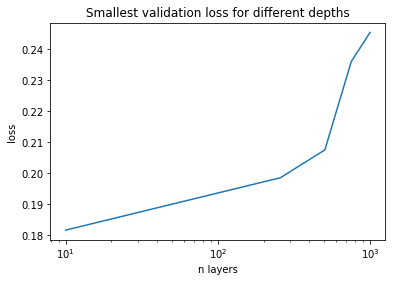

In [31]:

# Code to be tested
##############################################################################

# TODO Check that we actually have the right ammount of neurons


def make_model(features, labels, n_hidden_neurons):
    model = Sequential(
        [Dense(32, input_shape=features[0].shape, batch_size=128)])
    model.add(Activation('relu'))

    # Hidden layer
    model.add(Dense(n_hidden_neurons))
    model.add(Activation('relu'))

    # Output layer
    model.add(Dense(len(labels[0])))
    model.add(Activation("softmax"))

    model.compile(
        loss="categorical_crossentropy",
        metrics=["acc"],
        optimizer=optimizers.Adam(0.01)
    )
    return model


def task_4():

        n_hidden_neurons_list = np.linspace(10, 1000, 5)
        smallest_losses = []
        training_sets =[
                        (x_number_train,  y_number_train , "number" ),
                        (x_fashion_train, y_fashion_train, "fashion"),
                ]   
        for features, lables, name in training_sets:
                for n_hidden_neurons in n_hidden_neurons_list:
                        model = make_model(features, labels, n_hidden_neurons)
                        model.summary()
                        history = model.fit(
                                                features,
                                                labels,
                                                epochs=GLOBAL_N_EPOCHS, 
                                                batch_size=128, 
                                                validation_split=0.2
                                        )
                        title= "Exercise 4 ({}, {} hidden neurons)".format(name, n_hidden_neurons)
                        plot_history(history, title )
                        reckless_savefig(fig, "./plots/task_4/{}.png".format(title))


                        smallest_loss = np.min(history.history["loss"])
                        smallest_losses.append(smallest_loss)


                plt.semilogx(n_hidden_neurons_list[:len(smallest_losses)], smallest_losses)
                plt.title("Smallest validation loss for different depths")
                plt.xlabel("n layers")
                plt.ylabel("loss")
                reckless_savefig(plt, "./plots/task_4/{}_compare_number_of_hidden_nodes.png".format(name))


task_4()


Answer to question 2:

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

(60000, 784)
Train on 48000 samples, validate on 12000 samples
Epoch 1/4
48000/48000 [==============================] - 5s 103us/step - loss: 1369.6917 - acc: 0.0086 - val_loss: 1737.2305 - val_acc: 0.0029
Epoch 2/4
48000/48000 [==============================] - 3s 71us/step - loss: 1355.1982 - acc: 0.0124 - val_loss: 1925.5722 - val_acc: 0.0024
Epoch 3/4
48000/48000 [==============================] - 4s 84us/step - loss: 1353.5983 - acc: 0.0141 - val_loss: 2304.5889 - val_acc: 0.0013
Epoch 4/4
48000/48000 [==============================] - 4s 93us/step - loss: 1352.9735 - acc: 0.0153 - val_loss: 2040.9948 - val_acc: 0.0016
Train on 48000 samples, validate on 12000 samples
Epoch 1/4
48000/48000 [==============================] - 5s 95us/step - loss: 1429.1922 - acc: 0.0014 - val_loss: 1442.1515 - val_acc: 0.0018
Epoch 2/4
48000/48000 [==============================] - 3s 65us/step - loss: 1428.7861 - acc: 0.0015 - val_loss: 1442.3716 - val_acc: 0.0021
Epoch 3/4
48000/48000 [===========

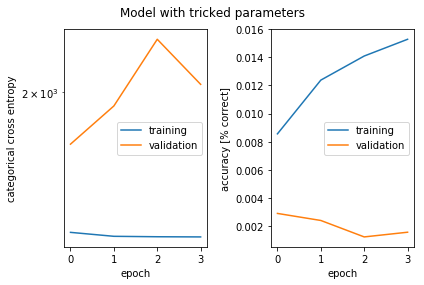

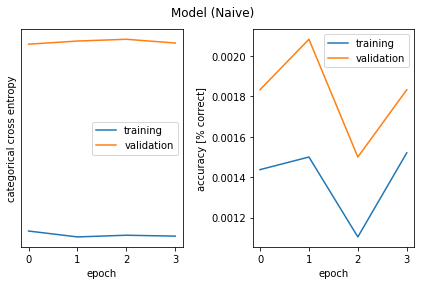

In [21]:

# Code to be tested
##############################################################################

# TODO: 
#  Add 
#        batch_normalisation (And experiment)
#        Dropout
#        |1 og |2 - regularisering

#  Plot learning curve og naive and the best from the experiments
#  Fit the spechalised one to the other dataset and plot the resulting curves. 
#%% 
def task_5_part_one():
    import scipy.optimize
    my_n_epochs = GLOBAL_N_EPOCHS*2
    
    learning_x = x_fashion_train
    learning_y = y_fashion_train
    print(learning_y.shape)
    print(learning_y.shape)
    optimizer = optimizers.SGD
    learning_rate = 0.1
    
    # Taks 1) and 2) 
    # Modified model 
    def test_modifyed_model(l1_value,l2_value, dropout_rate, just_scalar=False, use_normalisation=True, use_bias=True):
        normalized_model = Sequential( [Dense(32, input_shape=learning_x[0].shape, batch_size = DEBUG_BATCH_SIZE)] )
        for i in range(2): 
                normalized_model.add(Dense(50, kernel_regularizer=keras.regularizers.l1_l2(l1_value,l2_value) , use_bias=use_bias))
                # Extra changes
                if dropout_rate >0:
                    normalized_model.add(keras.layers.Dropout(dropout_rate))
                if use_normalisation == True:
                    normalized_model.add( keras.layers.normalization.BatchNormalization())
                normalized_model.add(Activation('sigmoid'))

        normalized_model.add(Dense(learning_y[0].shape[0], activation="softmax"))
        
        my_optimizer = optimizer(learning_rate)
        normalized_model.compile(
                      loss = "categorical_crossentropy", 
                      metrics = ["acc"],
                      optimizer= my_optimizer
                     )
        history = normalized_model.fit(learning_x, learning_y, epochs = my_n_epochs, batch_size = DEBUG_BATCH_SIZE, validation_split = 0.2)
        
        best_index = np.argmin(history.history["loss"]) 
        if just_scalar == True: 
            return 1- history.history["acc"][best_index]  # How large is the part that is correct
        else: 
            return history, 1- history.history["acc"][best_index] 

    
    
    # Naive model
    def test_naive_model(n_hidden_layers = 2):
        naive_model = Sequential( [Dense(32, input_shape=learning_x[0].shape, batch_size = 128)] )
        for i in range(n_hidden_layers): 
                naive_model.add(Dense(50))
                naive_model.add(Activation('sigmoid'))

        naive_model.add(Dense(learning_y[0].shape[0]))
        naive_model.add( Activation("softmax"))
        my_optimizer = optimizer(learning_rate)
        naive_model.compile(
                      loss = "categorical_crossentropy", 
                      metrics = ["acc"],
                      optimizer= my_optimizer
                     )
        history = naive_model.fit(learning_x, learning_y, epochs = my_n_epochs, batch_size = 128, validation_split = 0.2)
        return history
        
    def find_best_parameters(): 
        # Find a good set of parameters with Nelder-Mead
        def test_shell(objective_function, *args, **kwargs): 
            if np.min(args) > 0:
                history, value = objective_function(*args, **kwargs)

                f = open("logs/task_5_regularisation_trick_log.txt", "a")
                print( "l1, l2- value", list(args), kwargs,  "\t Value: ", value, file =f)
                f.close
                title = "Task 5 epochs {}, args: {}, kwargs: {}".format(my_n_epochs, args, kwargs)
                # "Task 5 "+  "epocs:"+ str(my_n_epochs)+ "args: "+str(args)+ "kwargs: "+str(kwargs)
                fig = plot_history(history, title)
                reckless_savefig(fig, "plots/task_5/"+title + ".png") # TODO Add plots/task_5/ to the beginning of this string
                plt.close(fig)
                # fig.close()
                return value
            acc = 100000
            for i in args:
                acc += - min( 0, i) # Add together all the incorrect values to guide back NM
            return acc

        # TODO Change this back
        # obj_fun_with_bias = lambda x: sum( i*i for i in x ) + sum( abs(i-1) for i in x )
        # obj_fun_without_bias = lambda x: 1+ sum( i*i for i in x ) + sum( abs(i-1) for i in x )
        obj_fun_with_bias  =    lambda x : test_shell( test_modifyed_model, *x, use_bias =True )
        obj_fun_without_bias  = lambda x : test_shell( test_modifyed_model, *x, use_bias = False)
        # print("TEST RUN OF OBJECTIVE FUNCTION")
        # obj_fun_with_bias([0.1,0.1,10])
        # print("TEST PASSED ")
        
        initial_simplex_without_bias = np.array( [
            (0.003950009934413591, 0.03213480931712963, 0.10797753772290808),
            (0.0008602709940843771, 0.021118115644290118, 0.08453217878372198),
            (0.008624306086033966, 0.002211304542824078, 0.07411051097393687),
            (0.0013125613425926073, 0.016706079861111105, 0.11970164609053496)  
            ]) # After an inital run, we changed the values to  the three latest samples, so that we can get a better start next time
        # Original initial simplex = [(0.000001, 0.000001, 0), (0.1, 0.1, 0.10) , (0.01, 0.1,0.10), (0.01, 0.1, 0.20)] 
        initial_simplex_with_bias = np.array( [
            (0.003950009934413591, 0.03213480931712963, 0.10797753772290808),
            (0.0008602709940843771, 0.021118115644290118, 0.08453217878372198),
            (0.008624306086033966, 0.002211304542824078, 0.07411051097393687),
            (0.0013125613425926073, 0.016706079861111105, 0.11970164609053496)  
            ])
        print(initial_simplex)
        optimizer_result_with_bias    = scipy.optimize.minimize(obj_fun_with_bias    , np.array([0.1,0.1,10]), method="Nelder-Mead", options = { "initial_simplex": initial_simplex, "maxiter": NELDER_MEAD_ITTERATIONS})
        optimizer_result_without_bias = scipy.optimize.minimize(obj_fun_without_bias , np.array([0.1,0.1,10]), method="Nelder-Mead", options = { "initial_simplex": initial_simplex, "maxiter": NELDER_MEAD_ITTERATIONS})

        # print("Best parameters with bias", optimizer_result_with_bias)
        # print("Best parameters without bias", optimizer_result_without_bias)
        print( "RESULT", optimizer_result_with_bias.fun, optimizer_result_with_bias.x )
        # modifyed_history, modifyed_best_loss = test_modifyed_model(*(best_arguments.x))
        
        if optimizer_result_with_bias.fun < optimizer_result_without_bias.fun:
            best_kwargs = { "use_bias" : True }
            best_args = optimizer_result_with_bias.x
            best_val = optimizer_result_with_bias.fun
        else: 
            best_kwargs = { "use_bias" : False }
            best_args = optimizer_result_without_bias.x
            best_val = optimizer_result_without_bias.fun
        
        #best_value = objective_functions(best_arguments)
        f = open("results/task_5.txt", "a")
        print("Best result form current itteration", best_args, best_kwargs, "=>", best_val, file =f)
        f.close()

        print("Lowest incorrectness= ", best_val)
        return best_args, best_kwargs , best_val
    #TODO : An actual search

    naive_history_0 = test_naive_model(n_hidden_layers =0)
    naive_fig_0 = plot_history(naive_history_0, "Model (Naive, depth = 0)")
    reckless_savefig(naive_fig_0,"plots/task_5/task_5_naive_0_epochs_" +str(my_n_epochs)+".png")

    naive_history_1 = test_naive_model(n_hidden_layers =1)
    naive_fig_1 = plot_history(naive_history_1, "Model (Naive, depth = 1)")
    reckless_savefig(naive_fig_1,"plots/task_5/task_5_naive_1_epochs_" +str(my_n_epochs)+".png")
    

    naive_history_2 = test_naive_model(n_hidden_layers =2)
    naive_fig_2 = plot_history(naive_history_2, "Model (Naive, depth = 2)")
    reckless_savefig(naive_fig_2,"plots/task_5/task_5_naive_2_epochs_" +str(my_n_epochs)+".png")
    

    
    best_args, best_kwargs, best_val = find_best_parameters()
    tricked_history, tricked_value = test_modifyed_model(*best_args, best_kwargs) 
    trick_fig = plot_history(tricked_history, "Model with tricked parameters")
    reckless_savefig(trick_fig,"plots/task_5/task_5_tricked_parameters.png")
    
    return best_args, best_kwargs, best_val
    
    # Task 3
    
def task_5_part_two(best_args, best_kwargs): 
    learning_x = x_number_train
    learning_y = y_number_train
    optimizer = optimizers.Adam
    learning_rate = 0.1
    my_n_epochs = GLOBAL_N_EPOCHS*2

    #Same as last time (But we can't have global variables (They kill the PC))
    def test_modifyed_model(l1_value,l2_value, dropout_rate, just_scalar=False, use_normalisation=True, use_bias=True):
        normalized_model = Sequential( [Dense(32, input_shape=learning_x[0].shape, batch_size = DEBUG_BATCH_SIZE)] )
        for i in range(2): 
                normalized_model.add(Dense(50, kernel_regularizer=keras.regularizers.l1_l2(l1_value,l2_value) , use_bias=use_bias))
                # Extra changes
                if dropout_rate >0:
                    normalized_model.add(keras.layers.Dropout(dropout_rate))
                if use_normalisation == True:
                    normalized_model.add( keras.layers.normalization.BatchNormalization())
                normalized_model.add(Activation('sigmoid'))

        normalized_model.add(Dense(learning_y[0].shape[0]))
        normalized_model.add( Activation("softmax"))
        my_optimizer = optimizer(learning_rate)
        normalized_model.compile(
                      loss = "categorical_crossentropy", 
                      metrics = ["acc"],
                      optimizer= my_optimizer
                     )
        history = normalized_model.fit(learning_x, learning_y, epochs = my_n_epochs, batch_size = DEBUG_BATCH_SIZE, validation_split = 0.2)
        
        best_index = np.argmin(history.history["loss"]) 
        if just_scalar == True: 
            return 1- history.history["acc"][best_index]  # How large is the part that is correct
        else: 
            return history, 1- history.history["acc"][best_index] 

    history_modifyed_model, best_value_modifyed_model= test_modifyed_model(*best_args, **best_kwargs, just_scalar=False) 
    fig = plot_history(history_modifyed_model, "Learnign history (Modifyed model on MNIST)")
    reckless_savefig(fig, "plots/task_5/Learning_history_modifyed_model_on_MNIST.png")
    
    
f = open("logs/task_5_regularisation_trick_log.txt", "a")
print("New run of exercise 5", "\n"+"#"*60, file =f)
f.close()

best_args, best_kwargs, best_value = task_5_part_one()
print(best_args, best_kwargs, best_value)
print(" THE BEST ARGUMENTS WE FOUND", best_args, best_kwargs)
task_5_part_two(best_args, best_kwargs)

#%%


Answer to question 2 (comments):

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [ ]:


    
def log(*args, file= None, **kwargs): 
    try:
        if log_file == None: 
            log_file = open("logs/task_6/main_log", "a") 
            print(*args, **kwargs, file=log_file)
            log_file.close()
        else: 
            print(*args, **kwargs, file=log_file)
    except: 
        print("Unable to write to log")
        print(*args, **kwargs)

log("#"*26, "Starting new run of task 6", sep="\n")

# Convolutional neural networks

def make_one_convolution_model(training_set, label_set): 
    # One convolution, two layers
    learning_rate = 0.004
    # n_labels = label_set.shape[1]
    num_classes = 10

    # Single later, but several convolutional layers
    output_model = Sequential()
    output_model.add(Conv2D(32*2, kernel_size=(4, 4),activation='linear',input_shape=(28,28,1),padding='same'))
    output_model.add(Activation("relu"))
    output_model.add(MaxPooling2D((4, 4),padding='same')) # I use max-polling because I decide to be stupid and not listen to others

    output_model.add(Flatten()) # We need a flattening layer (?) 
    output_model.add(Dense(128, activation='linear'))
    output_model.add(Activation("relu"))  
    output_model.add(Dense(128, activation='linear'))
    output_model.add(Activation("relu"))                   
    output_model.add(Dense(num_classes, activation='softmax'))

    output_model.compile( 
                    loss= "categorical_crossentropy",
                    metrics=["acc"],
                    optimizer=keras.optimizers.Adam(learning_rate)
    )
    output_model.summary()
    return output_model


def make_many_convolutions_model(training_set, label_set, learning_rate = 0.004): 
    # n_labels = label_set.shape[1]
    num_classes = 10

    # Single later, but several convolutional layers
    output_model = Sequential()
    output_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
    output_model.add(Activation("sigmoid"))
    output_model.add(MaxPooling2D((2, 2),padding='same')) # I use max-polling because I decide to be stupid and not listen to others
    output_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    output_model.add(Activation("sigmoid"))
    output_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    output_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    output_model.add(Activation("sigmoid"))                  
    output_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    output_model.add(Flatten())
    output_model.add(Dense(128, activation='linear'))
    output_model.add(Activation("sigmoid"))                  
    output_model.add(Dense(num_classes, activation='softmax'))

    output_model.compile( 
                    loss= "categorical_crossentropy",
                    metrics=["acc"],
                    optimizer=keras.optimizers.Adam(learning_rate)
    )
    output_model.summary()
    return output_model

def task_6_1(
    learning_x = x_number_train_raw[:,:,:,None],
    learning_y = y_number_train, 
    training_set_name = "MNIST"
): 

    my_n_epochs = GLOBAL_N_EPOCHS*2

    # Test the different models
    many_convolutions_model = make_many_convolutions_model(learning_x, learning_y)
    one_convolution_model = make_one_convolution_model(learning_x, learning_y)
    
    log("Start training the many convolutions net")
    many_convolutions_history = many_convolutions_model.fit(learning_x, learning_y, epochs = my_n_epochs, batch_size=DEBUG_BATCH_SIZE, validation_split=0.2)
    fig = plot_history(many_convolutions_history, "Task 6 "+training_set_name+" (Many convolutions) ")
    reckless_savefig(fig, "plots/task_6/"+training_set_name+"many_convolutions_network.png")
    # fig.savefig("plots/task_6/many_convolutions_network.png")
    
    plt.close(fig)
    log("Start training the one convolution, two layer net")

    one_convolution_history = one_convolution_model.fit( learning_x, learning_y, epochs = my_n_epochs, batch_size=DEBUG_BATCH_SIZE, validation_split=0.2)
    fig = plot_history(one_convolution_history, "Task 6 "+training_set_name+" (One convolution, 2 hidden layers)")
    reckless_savefig(fig, "plots/task_6/"+training_set_name+"__one_convolution_network.png")







if __name__ == "__main__":
    task_6_1(
        learning_x          =x_number_train_raw[:,:,:,None],
        learning_y          =y_number_train,
        training_set_name   ="MNIST_"
    )

    task_6_1(
        learning_x         = x_fashion_train_raw[:,:,:,None],
        learning_y         = y_fashion_train,
        training_set_name  ="Fashion_MNIST"
    )

Answer to question 3:

The convolutional neural networks look for certain kinds of features at each later, so it will simplify the information, while also having a bias towards solutions that are based on local properties (ie.edge detections at certain points, etc). Since it is quite possible that there are several weightings that can result in the same results on the training set, it stands to reason that the convolutional network will generalize better, given similair results on the training-data, sice real image classification is very dependent on locality and where things are placed relative to each other. 

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [1]:


    
def log(*args, file= None, **kwargs): 
    try:
        if log_file == None: 
            log_file = open("logs/task_7/main_log", "a") 
            print(*args, **kwargs, file=log_file)
            log_file.close()
        else: 
            print(*args, **kwargs, file=log_file)
    except: 
        print("Unable to write to log")
        print(*args, **kwargs)

log("#"*26, "Starting new run of task 6", sep="\n")

# Convolutional neural networks

def make_many_convolutions_model_unnormalized(training_set, label_set, learning_rate = 0.004): 
    # n_labels = label_set.shape[1]
    num_classes = 10

    # Single later, but several convolutional layers
    output_model = Sequential()
    output_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
    output_model.add(Activation("sigmoid"))
    output_model.add(MaxPooling2D((2, 2),padding='same')) # I use max-polling because I decide to be stupid and not listen to others
    output_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    output_model.add(Activation("sigmoid"))
    output_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    output_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    output_model.add(Activation("sigmoid"))                  
    output_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    output_model.add(Flatten())
    output_model.add(Dense(128, activation='linear'))
    output_model.add(Activation("sigmoid"))                  
    output_model.add(Dense(num_classes, activation='softmax'))

    output_model.compile( 
                    loss= "categorical_crossentropy",
                    metrics=["acc"],
                    optimizer=keras.optimizers.Adam(learning_rate)
    )
    output_model.summary()
    return output_model

def make_many_convolutions_model_batch_normalized(training_set, label_set, learning_rate = 0.004): 
    # n_labels = label_set.shape[1]
    num_classes = 10

    # Single later, but several convolutional layers
    output_model = Sequential()
    output_model.add(keras.layers.BatchNormalization())
    output_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
    output_model.add(Activation("sigmoid"))
    output_model.add(MaxPooling2D((2, 2),padding='same')) # I use max-polling because I decide to be stupid and not listen to others
    output_model.add(keras.layers.BatchNormalization())
    output_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    output_model.add(Activation("sigmoid"))
    output_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    output_model.add(keras.layers.BatchNormalization())
    output_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    output_model.add(Activation("sigmoid"))                  
    output_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    output_model.add(Flatten())
    output_model.add(keras.layers.BatchNormalization())
    output_model.add(Dense(128, activation='linear'))
    output_model.add(Activation("sigmoid"))                  
    output_model.add(Dense(num_classes, activation='softmax'))

    output_model.compile( 
                    loss= "categorical_crossentropy",
                    metrics=["acc"],
                    optimizer=keras.optimizers.Adam(learning_rate)
    )
    output_model.summary()
    return output_model


def task_7_1(
    learning_x = x_number_train_raw[:,:,:,None],
    learning_y = y_number_train, 
    training_set_name = "MNIST"
): 

    my_n_epochs = GLOBAL_N_EPOCHS*2

    # Test the different models
    many_convolutions_model = make_many_convolutions_model_unnormalized(learning_x, learning_y)
   
    log("Start training the many convolutions net")
    many_convolutions_history = many_convolutions_model.fit(learning_x, learning_y, epochs = my_n_epochs, batch_size=DEBUG_BATCH_SIZE, validation_split=0.2)
    fig = plot_history(many_convolutions_history, "Task 6 "+training_set_name+" (Many convolutions) ")
    reckless_savefig(fig, "plots/task_7/"+training_set_name+"many_convolutions_network.png")
    # fig.savefig("plots/task_7/many_convolutions_network.png")
    
    plt.close(fig)
    log("Start training the one convolution, two layer net")

  





if __name__ == "__main__":

    task_7_1(
        learning_x         = x_fashion_train_raw[:,:,:,None],
        learning_y         = y_fashion_train,
        training_set_name  ="Fashion_MNIST"
    )

Unable to write to log
##########################
Starting new run of task 6


NameError: name 'x_number_train_raw' is not defined

Answer to question 1:

Answer to question 2: